# EU Roads

# Libraries

In [1]:
pip install Infomap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.8/264.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Infomap: filename=infomap-2.8.0-cp312-cp312-linux_x86_64.whl size=7716614 sha256=0484c47a16bd8a1dfcb26011707283f082793447cfc4ed054881315544c119c4
  Stored in directory: /root/.cache/pip/wheels/0a/d5/d5/dab47e5b039fb1997c5ca2835ee7c9a7c7e1bf2615191aebb1
Successfully built Infomap


In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from collections import Counter
from scipy.stats import poisson
from scipy.stats import expon
from infomap import Infomap
import community.community_louvain as community_louvain
from collections import defaultdict
from matplotlib.lines import Line2D

# Read the network from the files

This section is written by AI

In [3]:
edges = pd.read_csv("edges.csv")
nodes = pd.read_csv("nodes.csv")
G = nx.Graph()

for _, row in nodes.iterrows():
    node_id = row["# index"]
    attrs = row.drop("# index").to_dict()
    G.add_node(node_id, **attrs)

for _, row in edges.iterrows():
    u = row["# source"]
    v = row[" target"]
    attrs = row.drop(["# source", " target"]).to_dict()
    G.add_edge(u, v, **attrs)

This is to check if the dataset has two distint "Brest" (France/Poland)

In [4]:
nodes[nodes[" meta"].str.contains("Brest", case=False, na=False)]

,# index,meta,_pos
401,401,Brest,"array([2.67771129, 2.76361195])"


In [5]:
print(nodes.head())
print(edges.head())

   # index         meta                             _pos
0        0     Greenock  array([1.69563397, 2.90766292])
1        1      Glasgow  array([1.73869647, 2.89200537])
2        2      Preston  array([1.71884408, 2.8463844 ])
3        3   Birmingham  array([1.71876562, 2.79931827])
4        4  Southampton  array([1.68482611, 2.77194074])
   # source   target
0         0        1
1         1        2
2         1       16
3         2        3
4         3        4


The graph is disconected (I found out later), so lets focus on the largest connected component

In [6]:
largest_cc = max(nx.connected_components(G), key=len)
roads = G.subgraph(largest_cc)

"roads" is now the graph we're going to analyze

# Basic descriptors

In [7]:
nnodes = roads.number_of_nodes()
nedges = roads.number_of_edges()
density = nx.density(roads)
avg_degree = 2 * nedges / nnodes

print("Nodes:", nnodes)
print("Edges:", nedges)
print("Density:", round(density, 4))
print("Average degree:", round(avg_degree, 4))

Nodes: 1039
Edges: 1305
Density: 0.0024
Average degree: 2.512


This are the nodes and edges of the largest component. The original had:
- Nodes: 1174
- Edges: 1417

Therefore 135 cities where disconected from the largest component, this is probably due to the islands found in Europe like Mallorca or Chipre

# Clustering

In [8]:
avg_clustering = nx.average_clustering(roads)
print("Average Clustering Coefficient:", round(avg_clustering, 4))

Average Clustering Coefficient: 0.0189


# Distances

In [9]:
avg_path_length = nx.average_shortest_path_length(roads)
diameter = nx.diameter(roads)

print("Average shortest path length:", round(avg_path_length, 4))
print("Diameter:", diameter)

Average shortest path length: 18.3951
Diameter: 62


Let's check which two cities are in the extremes of this diameter

In [10]:
# Compute all-pairs shortest paths
lengths = dict(nx.all_pairs_shortest_path_length(roads))
diameter = 0
u_diam, v_diam = None, None

# Just keep updating the diameter until you find the longest diameter
for u, dist_dict in lengths.items():
    for v, d in dist_dict.items():
        if d > diameter:
            diameter = d
            u_diam, v_diam = u, v

# City names
nodes_lcc = nodes[nodes['# index'].isin(roads)]
cities = pd.Series(nodes_lcc[' meta'].values, index=nodes_lcc['# index']).to_dict()
print("Furthest cities:", cities[u_diam], cities[v_diam])

Furthest cities: Rennesøy Gytheio


# Degree statistics

In [11]:
# First, we count the number of edges each node has (degree)
degrees = [roads.degree(n) for n in roads.nodes()]

# Then we count the amount of times each degree appears
degree_count = Counter(degrees)
k_values = sorted(degree_count.keys())

# Then the probability distribution
PDF = [degree_count[k] / len(G.nodes()) for k in k_values]

# Then the complementary cumulative distribution
CDF = np.zeros(len(PDF))
CCDF = np.zeros(len(PDF))
CDF[0] = PDF[0]
CCDF[0] = 1

for n in range(len(PDF)-1):
  CDF[n+1] = CDF[n] + PDF[n+1]
  CCDF[n+1] = 1 - CDF[n+1]

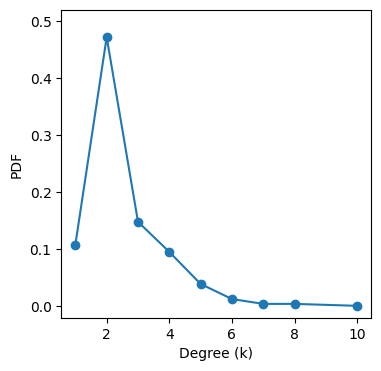

In [12]:
plt.figure(figsize=(4, 4))
plt.plot(k_values, PDF, 'o-')
plt.xlabel("Degree (k)")
plt.ylabel("PDF")
plt.ylim([-0.02,0.52])
plt.grid(False)
plt.savefig("PDF.png", bbox_inches='tight')

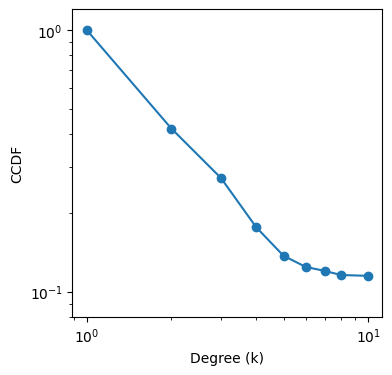

In [13]:
plt.figure(figsize=(4, 4))
plt.loglog(k_values, CCDF, 'o-')
plt.xlabel("Degree (k)")
plt.ylabel("CCDF")
plt.ylim([0.08,1.2])
plt.grid(False)
plt.savefig("CCDF.png", bbox_inches='tight')

Fitting distributions

In [14]:
k_values = np.array(k_values)
degrees = np.array(degrees)

# Poisson distribution (Random networks)
lambda_hat = degrees.mean()
ccdf_poisson = poisson.sf(k_values - 1, lambda_hat)

# Eponential distribution (Small word)
kmin = degrees.min()
lambda_exp = 1 / (degrees.mean() - kmin)
ccdf_exponential = expon.sf(k_values - kmin, scale=1/lambda_exp)

# Power law
kmin_pl = kmin
data_pl = degrees[degrees >= kmin_pl]
alpha_hat = 1 + len(data_pl) / np.sum(np.log(data_pl / kmin_pl))
ccdf_powerlaw = (k_values / kmin_pl) ** (1 - alpha_hat)

Plots

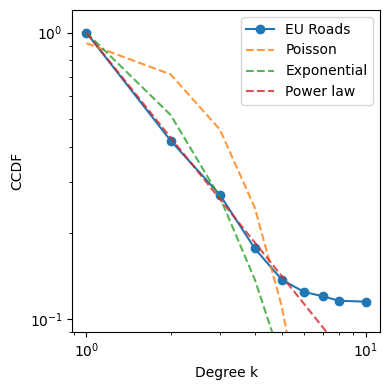

In [15]:
plt.figure(figsize=(4,4))

plt.loglog(k_values, CCDF, 'o-', label="EU Roads")
plt.loglog(k_values, ccdf_poisson, '--', label="Poisson", alpha=0.8)
plt.loglog(k_values, ccdf_exponential, '--', label="Exponential", alpha=0.8)
plt.loglog(k_values, ccdf_powerlaw, '--', label="Power law", alpha=0.8)

plt.xlabel("Degree k")
plt.ylabel("CCDF")
plt.ylim([0.09,1.2])
plt.legend()
plt.tight_layout()
plt.savefig("Distribution comparisons.png", bbox_inches='tight')

It's clearly a power law (-1) distribution, making it a similar-ish distribution to the frequency of word ussage in a language

# Centrality structure

Must run "Distances" first

All the parameters

In [16]:
city_names = list(cities.values())
city_deg = np.array([k for x,k in dict(nx.degree(roads)).items()])
city_closenness = np.array([x for k,x in nx.closeness_centrality(roads).items()])
city_betweenness = np.array([x for k,x in nx.betweenness_centrality(roads).items()])
city_eigenvector = np.array([x for k,x in nx.eigenvector_centrality(roads,max_iter=1000).items()])
city_katz = np.array([x for k,x in nx.katz_centrality(roads,alpha=0.005,beta=1.0,max_iter=1000).items()])
city_pagerank = np.array([x for k,x in nx.pagerank(roads,alpha=0.85).items()])
city_subgraph = np.array([x for k,x in nx.subgraph_centrality(roads).items()])

Just a nice table with everything

In [17]:
df = pd.DataFrame({
    "Name": city_names,
    "Degree": city_deg,
    "Closeness": city_closenness,
    "Betweenness": city_betweenness,
    "Eigenvector": city_eigenvector,
    "Katz": city_katz,
    "Pagerank": city_pagerank,
    "Subgraph": city_subgraph,
    })
df

,Name,Degree,Closeness,Betweenness,Eigenvector,Katz,Pagerank,Subgraph
0,Le Havre,2,0.072919,0.001635,1.095001e-01,0.030946,0.000667,2.757291
1,Paris,8,0.078506,0.184288,3.651319e-01,0.031883,0.002215,11.791322
2,Orléans,5,0.075033,0.122849,2.016486e-01,0.031417,0.001444,7.386311
3,Bordeaux,5,0.071218,0.015318,1.315580e-01,0.031414,0.001525,7.513837
4,San Sebastián,4,0.067848,0.018493,7.537399e-02,0.031257,0.001258,5.478180
...,...,...,...,...,...,...,...,...
1034,Vonitsa,2,0.040771,0.001927,3.684691e-09,0.030941,0.001068,2.228951
1035,Amfilochia,2,0.042499,0.003850,1.372649e-08,0.030942,0.000976,2.283747
1036,Karpenisi,2,0.044376,0.005769,5.090984e-08,0.030944,0.000889,2.483351
1037,Sparti,2,0.036436,0.001927,3.805994e-11,0.030942,0.001009,2.284563


Ranking

In [18]:
# This funtion is written by AI
def top_n(df, column, n=25):
    return (
        df[["Name", column]]
        .sort_values(column, ascending=False)
        .head(n)
        .reset_index(drop=True)
    )

top25_degree = top_n(df, "Degree")
top25_closeness = top_n(df, "Closeness")
top25_betweenness = top_n(df, "Betweenness")
top25_eigenvector = top_n(df, "Eigenvector")
top25_katz = top_n(df, "Katz")
top25_pagerank = top_n(df, "Pagerank")
top25_subgraph = top_n(df, "Subgraph")

top25_table = pd.DataFrame({
    "Degree": top25_degree["Name"].values,
    "Closeness": top25_closeness["Name"].values,
    "Betweenness": top25_betweenness["Name"].values,
    "Eigenvector": top25_eigenvector["Name"].values,
    "Katz": top25_katz["Name"].values,
    "PageRank": top25_pagerank["Name"].values,
    "Subgraph": top25_subgraph["Name"].values,
})

top25_table.index += 1
top25_table

,Degree,Closeness,Betweenness,Eigenvector,Katz,PageRank,Subgraph
1,Moscow,Warsaw,Brest,Paris,Moscow,Moscow,Moscow
2,Paris,Brest,Moscow,Metz,Paris,Berlin,Paris
3,Munich,Minsk,Saint Petersburg,Reims,Munich,Budapest,Munich
4,Berlin,Lviv,Le Mans,Brussels,Liège,Liège,Liège
5,Budapest,Lublin,Rennes,Liège,Berlin,Munich,Vienna
6,Liège,Kaunas,Minsk,Le Mans,Budapest,Paris,Bratislava
7,Metz,Rennes,Warsaw,Orléans,Metz,Larissa,Metz
8,Warsaw,Smolensk,Smolensk,Luxembourg,Vienna,İzmir,Berlin
9,Prague,Piotrków Trybunalski,Vyborg,Charleville-Mézières,Bratislava,Malmö,Budapest
10,Vienna,Moscow,Vaalimaa,Lyon,Warsaw,Bratislava,Brno


Just to translate it into LaTeX

In [19]:
top25_table.index.name = "Rank"
top25_table.to_latex(
    index=True,
    caption="Top 25 cities in centrality parameters"
)

'\\begin{table}\n\\caption{Top 25 cities in centrality parameters}\n\\begin{tabular}{llllllll}\n\\toprule\n & Degree & Closeness & Betweenness & Eigenvector & Katz & PageRank & Subgraph \\\\\nRank &  &  &  &  &  &  &  \\\\\n\\midrule\n1 & Moscow & Warsaw & Brest & Paris & Moscow & Moscow & Moscow \\\\\n2 & Paris & Brest & Moscow & Metz & Paris & Berlin & Paris \\\\\n3 & Munich & Minsk & Saint Petersburg & Reims & Munich & Budapest & Munich \\\\\n4 & Berlin & Lviv & Le Mans & Brussels & Liège & Liège & Liège \\\\\n5 & Budapest & Lublin & Rennes & Liège & Berlin & Munich & Vienna \\\\\n6 & Liège & Kaunas & Minsk & Le Mans & Budapest & Paris & Bratislava \\\\\n7 & Metz & Rennes & Warsaw & Orléans & Metz & Larissa & Metz \\\\\n8 & Warsaw & Smolensk & Smolensk & Luxembourg & Vienna & İzmir & Berlin \\\\\n9 & Prague & Piotrków Trybunalski & Vyborg & Charleville-Mézières & Bratislava & Malmö & Budapest \\\\\n10 & Vienna & Moscow & Vaalimaa & Lyon & Warsaw & Bratislava & Brno \\\\\n11 & Bratis

Let's rank the cities by appearance

In [20]:
cities_all = top25_table.stack()
city_counts = cities_all.value_counts()

df_frequency = city_counts.reset_index()
df_frequency.columns = ["City", "Appearances"]
df_frequency["Rank"] = df_frequency["Appearances"].rank(
    method="dense", ascending=False
).astype(int)

df_frequency = df_frequency.sort_values(
    ["Appearances", "City"], ascending=[False, True]
)
df_frequency.head(17)

,City,Appearances,Rank
0,Moscow,6,1
2,Paris,6,1
1,Warsaw,6,1
6,Kiev,5,2
4,Liège,5,2
5,Lyon,5,2
3,Metz,5,2
14,Berlin,4,3
9,Bratislava,4,3
8,Budapest,4,3


This is a note for myself:
- Degree: How many direct connections a node has.
- Closeness: How close a node is to all others (shortest paths).
- Betweenness: How often a node lies on shortest paths.
- Eigenvector: Importance via connections to important nodes.
- Katz: Eigenvector-like, but includes distant nodes with attenuation.
- Pagerank: Random-walk importance.
- Subgraph: Nodes embedded in dense local structure.

# Null Models

I don't see the point of analyzing the centrality structure and the comunities of random networks so I'm just going to look at points 1-4

Must run "Basic descriptors" first

We start with Erdos Reyni

This section is like 30% clasroom notes, 30% me and 40% AI

In [21]:
densityER = np.zeros(10)
avg_clusterER = np.zeros(10)
avg_clusteringER = np.zeros(10)
avg_path_lengthER = np.zeros(10)
diameterER = np.zeros(10)
pdf_list = []
cdf_list = []
ccdf_list = []
k_list = []

for i in range(10):
  ER = nx.gnm_random_graph(nnodes,nedges)
  ER = ER.subgraph(max(nx.connected_components(ER), key=len)).copy() # Largest component

  # Basic stats
  densityER[i] = nx.density(ER)
  avg_clusteringER[i] = nx.average_clustering(ER)
  avg_path_lengthER[i] = nx.average_shortest_path_length(ER)
  diameterER[i] = nx.diameter(ER)

  # Degree distribution
  degrees = [ER.degree(n) for n in ER.nodes()]
  degree_count = Counter(degrees)
  k_valuesER = sorted(degree_count.keys())
  PDFER = [degree_count[k] / len(ER.nodes()) for k in k_valuesER]
  CDFER = np.zeros(len(PDFER))
  CCDFER = np.zeros(len(PDFER))
  CDFER[0] = PDFER[0]
  CCDFER[0] = 1

  for n in range(len(PDFER)-1):
    CDFER[n+1] = CDFER[n] + PDFER[n+1]
    CCDFER[n+1] = 1 - CDFER[n+1]

  k_list.append(k_valuesER)
  pdf_list.append(PDFER)
  cdf_list.append(CDFER)
  ccdf_list.append(CCDFER)

print("Density:", round(np.mean(densityER), 6), "±", round(np.std(densityER), 6))
print("Average Clustering Coefficient:", round(np.mean(avg_clusteringER), 6), "±", round(np.std(avg_clusteringER), 6))
print("Average shortest path length:", round(np.mean(avg_path_lengthER), 4), "±", round(np.std(avg_path_lengthER), 4))
print("Diameter:", round(np.mean(diameterER), 4), "±", round(np.std(diameterER), 4))

# Average for the distributions
k_allER = np.unique(np.concatenate(k_list))
pdf_mat = np.zeros((10, len(k_allER)))
cdf_mat = np.zeros((10, len(k_allER)))
ccdf_mat = np.zeros((10, len(k_allER)))

for i in range(10):
    idx = np.searchsorted(k_allER, k_list[i])

    pdf_mat[i, idx] = pdf_list[i]
    cdf_mat[i, idx] = cdf_list[i]
    ccdf_mat[i, idx] = ccdf_list[i]

pdf_meanER = pdf_mat.mean(axis=0)
pdf_stdER = pdf_mat.std(axis=0)

ccdf_meanER = ccdf_mat.mean(axis=0)
ccdf_stdER = ccdf_mat.std(axis=0)

Density: 0.003004 ± 4.6e-05
Average Clustering Coefficient: 0.002048 ± 0.000941
Average shortest path length: 7.2799 ± 0.111
Diameter: 17.8 ± 1.6


Next, Barabasi Albert

In [22]:
nedgesBA = np.zeros(10)
densityBA = np.zeros(10)
avg_clusterBA = np.zeros(10)
avg_clusteringBA = np.zeros(10)
avg_path_lengthBA = np.zeros(10)
diameterBA = np.zeros(10)
pdf_list = []
cdf_list = []
ccdf_list = []
k_list = []

for i in range(10):
  BA = nx.barabasi_albert_graph(nnodes,int(avg_degree / 2))
  BA = BA.subgraph(max(nx.connected_components(BA), key=len)).copy() # Largest component

  nedgesBA[i] = nx.number_of_edges(BA)
  densityBA[i] = nx.density(BA)
  avg_clusteringBA[i] = nx.average_clustering(BA)
  avg_path_lengthBA[i] = nx.average_shortest_path_length(BA)
  diameterBA[i] = nx.diameter(BA)

  # Degree distribution
  degrees = [BA.degree(n) for n in BA.nodes()]
  degree_count = Counter(degrees)
  k_valuesBA = sorted(degree_count.keys())
  PDFBA = [degree_count[k] / len(BA.nodes()) for k in k_valuesBA]
  CDFBA = np.zeros(len(PDFBA))
  CCDFBA = np.zeros(len(PDFBA))
  CDFBA[0] = PDFBA[0]
  CCDFBA[0] = 1

  for n in range(len(PDFBA)-1):
    CDFBA[n+1] = CDFBA[n] + PDFBA[n+1]
    CCDFBA[n+1] = 1 - CDFBA[n+1]

  k_list.append(k_valuesBA)
  pdf_list.append(PDFBA)
  cdf_list.append(CDFBA)
  ccdf_list.append(CCDFBA)

print("Nº Edges:", round(np.mean(nedgesBA), 4), "±", round(np.std(nedgesBA), 10))
print("Density:", round(np.mean(densityBA), 4), "±", round(np.std(densityBA), 10))
print("Average Clustering Coefficient:", round(np.mean(avg_clusteringBA), 10), "±", round(np.std(avg_clusteringBA), 10))
print("Average shortest path length:", round(np.mean(avg_path_lengthBA), 4), "±", round(np.std(avg_path_lengthBA), 4))
print("Diameter:", round(np.mean(diameterBA), 4), "±", round(np.std(diameterBA), 4))

# Average for the distributions
k_allBA = np.unique(np.concatenate(k_list))
pdf_mat = np.zeros((10, len(k_allBA)))
cdf_mat = np.zeros((10, len(k_allBA)))
ccdf_mat = np.zeros((10, len(k_allBA)))

for i in range(10):
    idx = np.searchsorted(k_allBA, k_list[i])

    pdf_mat[i, idx] = pdf_list[i]
    cdf_mat[i, idx] = cdf_list[i]
    ccdf_mat[i, idx] = ccdf_list[i]

pdf_meanBA = pdf_mat.mean(axis=0)
pdf_stdBA = pdf_mat.std(axis=0)

ccdf_meanBA = ccdf_mat.mean(axis=0)
ccdf_stdBA = ccdf_mat.std(axis=0)

Nº Edges: 1038.0 ± 0.0
Density: 0.0019 ± 0.0
Average Clustering Coefficient: 0.0 ± 0.0
Average shortest path length: 7.3935 ± 0.6167
Diameter: 18.8 ± 2.5612


Figures for the degree distributions

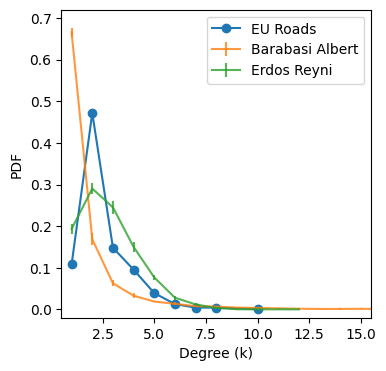

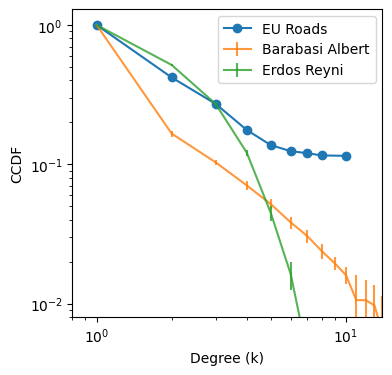

In [23]:
plt.figure(figsize=(4, 4))
plt.plot(k_values, PDF, 'o-', label='EU Roads')
plt.errorbar(k_allBA, pdf_meanBA, yerr=pdf_stdBA, label='Barabasi Albert', alpha=0.8)
plt.errorbar(k_allER, pdf_meanER, yerr=pdf_stdER, label='Erdos Reyni', alpha=0.8)
plt.xlabel("Degree (k)")
plt.ylabel("PDF")
plt.xlim([0.5,15.5])
plt.ylim([-0.02,0.72])
plt.grid(False)
plt.legend()
plt.savefig("PDFrand.png", bbox_inches='tight')

plt.figure(figsize=(4, 4))
plt.plot(k_values, CCDF, 'o-', label="EU Roads")
plt.errorbar(k_allBA, ccdf_meanBA, yerr=ccdf_stdBA, label='Barabasi Albert', alpha=0.8)
plt.errorbar(k_allER, ccdf_meanER, yerr=ccdf_stdER, label='Erdos Reyni', alpha=0.8)
plt.xlabel("Degree (k)")
plt.ylabel("CCDF")
plt.xscale("log")
plt.yscale("log")
plt.xlim([0.8,14])
plt.ylim([0.008,1.3])
plt.grid(False)
plt.legend()
plt.savefig("CCDFrand.png", bbox_inches='tight')

# Communities

Where using a random walk based community detector since I belive it makes the most sense for a network based on roads connecting cities

In [24]:
im = Infomap()
mapping = im.add_networkx_graph(roads)
im.run()

communities_dict = {}
for node in im.tree:
    if node.is_leaf:
        #print(node.node_id, node.module_id)
        communities_dict[node.node_id] = node.module_id

N_comm = np.max(list(communities_dict.values()))
communities_im = N_comm*[[]]

for i in range(N_comm):
    communities_im[i] = [node for node in communities_dict.keys() if communities_dict[node]==i+1]

print(communities_im)
print("Amount of communities:",len(communities_im))

[[38, 410, 412, 875, 411, 413, 39, 40, 1013, 1014, 1028, 64, 632, 63, 393, 841, 986, 987, 990, 988, 989, 991, 22, 536, 537, 23, 24, 538, 1108, 1109, 621, 1077, 1110, 11, 558, 26, 10, 29, 559, 27, 28, 25, 68, 69, 415, 416, 669, 414, 629, 42, 41, 454, 455, 881, 456, 882, 452, 884, 478, 477, 883, 619, 620, 1022, 100, 668, 102, 396, 394, 101, 103, 395, 6, 453, 880, 5, 879, 7, 8, 560, 9, 33, 13, 30, 31, 32, 1158, 1157, 408, 21, 861, 409, 1026, 12, 593, 594, 595, 1137, 1136, 36, 1010, 37, 1011, 1012, 597, 1073, 596, 1072, 1071, 1074, 873, 871, 872, 874, 870, 1027, 627, 481, 479, 480, 67, 65, 66, 862, 35, 34, 391, 392, 630, 876, 877, 878, 264, 507, 549, 751, 752, 505, 508, 506, 750, 550, 741, 1047, 1052, 498, 180, 179, 178, 234, 497, 1048, 1049, 1050, 1031, 400, 423, 228, 231, 399, 229, 230, 730, 503, 909, 504, 738, 748, 749, 739, 740, 737, 1051, 464, 258, 261, 747, 263, 465, 466, 259, 260, 262, 895, 467, 893, 469, 1065, 1066, 894, 468, 1064, 1067, 511, 280, 757, 509, 510, 755, 756, 758, 1068

Only two communities is kinda bad so I'm going to try Louvain (Modularity)

In [25]:
partition = community_louvain.best_partition(roads)

communities = defaultdict(list)

for node, comm in partition.items():
    communities[comm].append(node)

communities_lv = list(communities.values())

print(communities_lv)
print("Amount of communities:",len(communities_lv))

[[5, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 63, 64, 65, 66, 67, 68, 69, 70, 100, 101, 102, 103, 391, 392, 393, 394, 395, 396, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 453, 454, 455, 456, 629, 630, 632, 668, 841, 862, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 986, 987, 988, 989, 990, 991, 1010, 1011, 1012, 1013, 1014, 1027, 1028], [6, 7, 8, 9, 21, 22, 44, 45, 401, 408, 409, 451, 452, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 536, 560, 596, 597, 619, 620, 621, 627, 861, 883, 884, 888, 899, 900, 1022, 1023, 1024, 1026, 1035, 1071, 1072, 1073, 1074, 1077, 1108, 1110], [10, 11, 12, 13, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 558, 559, 593, 594, 595, 1109, 1136, 1137, 1157, 1158], [46, 47, 71, 72, 73, 74, 75, 76, 77, 78, 79, 104, 105, 106, 107, 108, 109, 141, 142, 143, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 669, 670, 671, 672, 673, 674, 675, 676, 695, 696, 887, 889, 890, 891, 892, 1036, 1039, 1040, 1041, 1043, 1078, 

Modularity score

In [26]:
mod_im = nx.algorithms.community.modularity(roads,communities_im)
qual_im = nx.algorithms.community.partition_quality(roads,communities_im)
mod_lv = nx.algorithms.community.modularity(roads,communities_lv)
qual_lv = nx.algorithms.community.partition_quality(roads,communities_lv)

print('Infomap optimization:',mod_im)
print('Infomap (coverage,performance):',qual_im)
print('Louvain optimization:',mod_lv)
print('Louvain (coverage,performance):',qual_lv)

Infomap optimization: 0.2078008250025689
Infomap (coverage,performance): (0.9984674329501916, 0.2414152484696082)
Louvain optimization: 0.8664681962977643
Louvain (coverage,performance): (0.9187739463601533, 0.952375653928392)


# Visualization

Colors based on communities (must run "Communities" first)

In [27]:
node_to_comm = {}

for comm_id, nodes in enumerate(communities_lv):
    for node in nodes:
        node_to_comm[node] = comm_id

cmap = plt.cm.get_cmap("hsv", len(communities))
regions = [cmap(node_to_comm[n]) for n in roads.nodes()]

# Unfortunately, the community detection orders the regions randomly, so this list only worked for the initial graph (uploaded somewhere)
region_names = [
    "Atlantic Iberia",
    "Western Europe",
    "Iberian Peninsula",
    "Northwestern Europe",
    "Alpine Region",
    "Italian Peninsula",
    "Scandinavian South",
    "Southern Balkans",
    "Central-Eastern Europe",
    "Central Europe",
    "Western Balkans",
    "Arctic Scandinavia",
    "Baltic–Eastern Europe",
    "Eastern Europe",
    "Balkan–Anatolian Transition",
    "Russia Core",
    "Eurasian Steppe (West)",
    "Central Asian Highlands",
    "Central Asian Steppe",
    "South Caucasus",
    "Anatolia",
    "Scandinavia",
    "Scandinavia",
]


legend_elements = [
    Line2D([0], [0],
           marker='o',
           color='w',
           markerfacecolor=cmap(i),
           markersize=30,
           label=region_names[i])
    for i in range(len(region_names))
    ]

/tmp/ipython-input-1834291957.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("hsv", len(communities))


Must run "Centrality structure" first

/usr/local/lib/python3.12/dist-packages/networkx/drawing/nx_pylab.py:1497: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


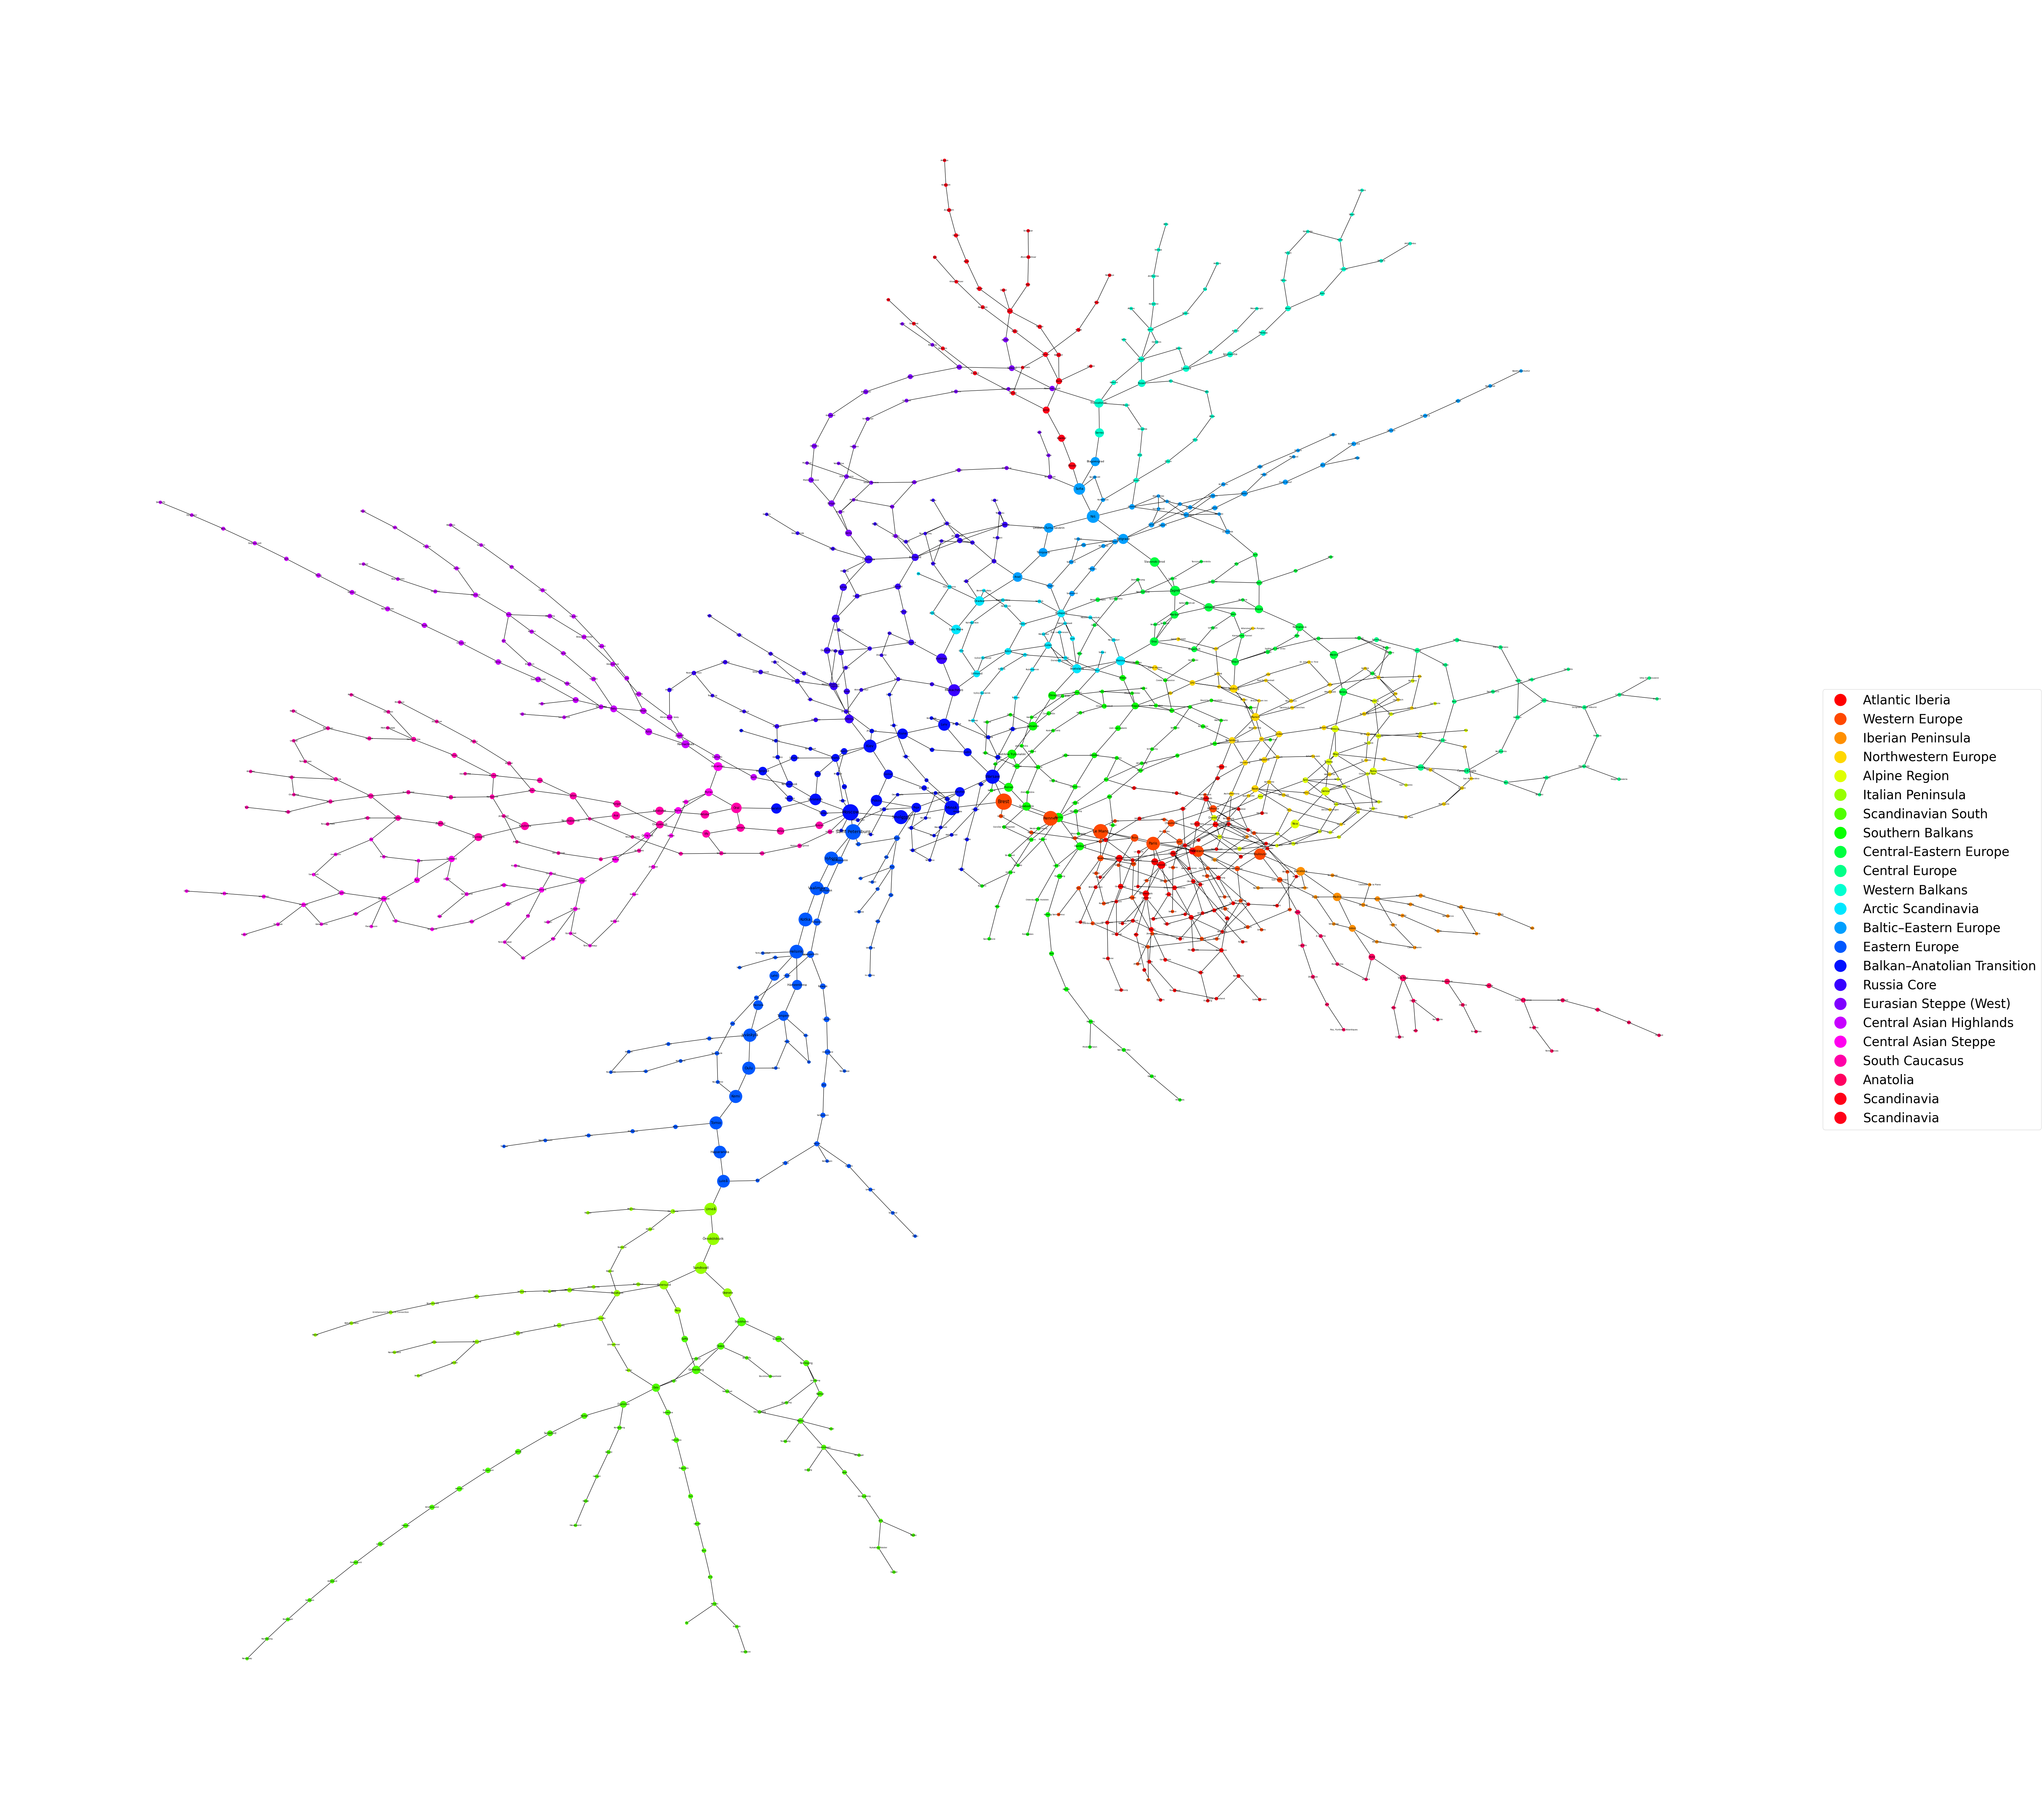

In [28]:
plt.figure(figsize=(60,60))

nx.draw(
    roads,
    pos=nx.kamada_kawai_layout(roads),
    with_labels=False,
    #labels=cities,
    node_color=regions,
    cmap='GnBu',
    #node_size=100*city_deg
    #node_size=1000000*(city_closenness**3)
    node_size=50+5000*city_betweenness
    )

# Font size proportional to city betweeness (It couldn't be done by simple means so this section is written by AI sorry!!)
city_betweenness_dict = dict(zip(roads.nodes, city_betweenness))
font_sizes = {node: 5 + 20 * city_betweenness_dict[node] for node in roads.nodes}
labels = {node: cities[node] for node in roads.nodes}
nx.draw_networkx_labels(roads, pos=nx.kamada_kawai_layout(roads), labels=labels)
for text in plt.gca().texts:
    node = [n for n, lbl in cities.items() if lbl == text.get_text()][0]
    text.set_fontsize(font_sizes[node])

plt.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=30
    )

plt.savefig("EU Roads Network.png", bbox_inches="tight")